# Illustrate comparisons to Sicklick 2019
We investigated how highlights made by the Molecular Oncology Almanac compare to those made in the trial I-PREDICT. We create the following figures:

1. Counts of therapies administered per patient (custom figure)
2. Therapies by evidence for those (stacked bar charts)
    * administered to patients in I-PREDICT
    * highlighted by the Molecular Oncology Almanac
3. Counts of (scatter plots)
    * therapies
    * thearpeutic strategy
    * molecular features targeted
    
Lastly, we'll generate some summary statistics and findings which are of particularly of note.

## Import

In [1]:
import glob
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy
import pandas

import sys
sys.path.append('../../common/')
import settings
settings.set_arial_as_font()

from matplotlib import colors
%matplotlib inline

features = pandas.read_csv('merged-features.annotated.txt', sep='\t')
therapies = pandas.read_csv('therapies.annotated.txt', sep='\t')

def normalize_rgb(dictionary):
    for color in dictionary.keys():
        r, g, b = dictionary[color]
        dictionary[color] = (r / 255., g / 255., b / 255.)
    return dictionary
def return_cmap_norm(normalized_rgb, bounds):
    cmap = colors.ListedColormap(normalized_rgb)
    norm = colors.BoundaryNorm(bounds, cmap.N)
    return cmap, norm

tableau = normalize_rgb({
    'red': (198, 4, 4), 'blue': (48, 100, 147), 'purple': (167, 136, 168),
    #'red': (221, 76, 78), 'purple': (166, 111, 151), 'blue': (68, 109, 157)
})

purple = '#A788A8'
blue = '#306493'
red = '#CC0000'
green = '#49ae3e'
orange = '#ec7b22'

In [2]:
features.columns

Index(['feature', 'feature_type', 'alteration_type', 'alteration',
       'patient_id', 'ipredict_targeted', 'score_bin',
       'sensitive_predictive_implication', 'resistance_predictive_implication',
       'prognostic_predictive_implication', 'sensitive_score_bin',
       'sensitive_therapy_name', 'sensitive_therapy_strategy',
       'sensitive_therapy_type', 'sensitive_description', 'sensitive_citation',
       'sensitive_url', 'resistance_score_bin', 'resistance_therapy_name',
       'resistance_therapy_strategy', 'resistance_therapy_type',
       'resistance_description', 'resistance_citation', 'resistance_url',
       'prognostic_score_bin', 'favorable_prognosis', 'prognostic_description',
       'prognostic_citation', 'prognostic_url'],
      dtype='object')

In [3]:
therapies.columns

Index(['patient_id', 'therapy', 'study-evidence-strongest',
       'almanac-evidence-strongest', 'included-in-overlapping-strategy',
       'strategy', 'study-gave-as-matched-therapy',
       'study-citations-used-for-patient', 'comment-on-study-citation',
       'substrategy', 'almanac_top_recommendation_group'],
      dtype='object')

In [4]:
def display_label(data, ax, min_x, min_y, index_value, fontsize=16, add_x=0, add_y=0):
    x = data.loc[index_value, 'label_x']
    y = data.loc[index_value, 'label_y']
    
    if (((x > 5) & (y > 5)) | (x > min_x) | (y > min_y)):
        ax.annotate(index_value, (x + add_x, y + add_y), fontsize=fontsize)

def label_by_height(data, ax, fontsize=16):
    labels = []
    count = 0
    
    for index in data.index:
        labels.append('')
    for index in data.index:
        labels.append(data.loc[index, 'percent agree'])
        
    for i in ax.patches:
        if count >= 6:
            ax.text(i.get_x() + 0.1, i.get_y() + i.get_height() + 2, labels[count], 
                    fontsize=fontsize, color=purple, fontweight='semibold')
        count += 1
        
def remove_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

def remove_ticks(ax,
                 bottom=False, top=False, left=False, right=False,
                 labelbottom=False, labeltop=True, labelleft=False, labelright=False):
    ax.tick_params(
        axis="both", which="both", 
        bottom=bottom, top=top, left=left, right=right,
        labelbottom=labelbottom, labeltop=labeltop, labelleft=labelleft, labelright=labelright) 
    
def roundup(x, n):
    return int(int(math.ceil(x / n)) * n)

## 1. Counts of therapies administered per patient (custom figure)
We will process the therapies dataframe to create a dataframe that shows: 
1. the number of therapies administered per patient by I-PREDICT on the left (blue)
2. the number of therapies highlighted per patient by Molecular Oncology Almanac on the right (red)
3. the number of these therapies that were involved in overlapping strategy for both sides (purple)

This will be labeled as `data_s`. This was originally Figure 4A but was moved to the supplement.

In [5]:
series_list = []
for label, group in therapies.groupby('patient_id'):
    total_therapies = group.shape[0]
    idx_study = group['study-gave-as-matched-therapy'].notnull()
    idx_almanac = group['almanac-evidence-strongest'].notnull()
    idx_overlap = group['included-in-overlapping-strategy'].fillna(0).astype(int).eq(1)
    
    sum_overlap = group['included-in-overlapping-strategy'].fillna(0.0).astype(float).sum()
    
    study_overlap = group[idx_study & idx_overlap].shape[0]
    almanac_overlap = group[idx_almanac & idx_overlap].shape[0]
    
    dictionary = {
        'total': total_therapies,
        'study': group[idx_study].shape[0],
        'almanac': group[idx_almanac].shape[0],
        'study_overlap': study_overlap,
        'almanac_overlap': almanac_overlap,
        'overlap': sum_overlap
    }
    series = pandas.Series(dictionary, name=label)
    series_list.append(series)

data = pandas.concat(series_list, axis=1).T.reset_index().rename(columns={'index': 'patient_id'})
data['study_not_overlap'] = data['study'].subtract(data['study_overlap'])
data['almanac_not_overlap'] = data['almanac'].subtract(data['almanac_overlap'])

sort_columns = ['overlap', 'study', 'almanac']
data = data.sort_values(sort_columns, ascending=True)

data_s = data.copy(deep=True)

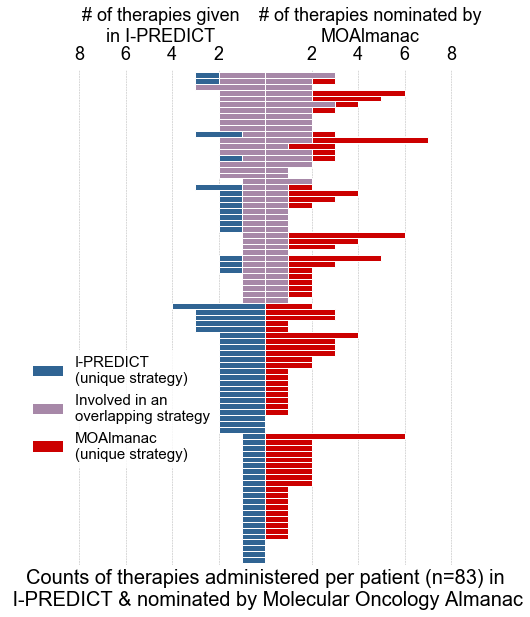

In [6]:
font_size_legend = 15
font_size_data = 16
font_size_axis_label = 18
font_size_tick_params = 18
font_size_title_minor = 20
font_size_title_major = 22

figure = plt.figure(figsize=(7.5, 10))
gs = figure.add_gridspec(nrows=3, ncols=2)
gsA = gs[:,:].subgridspec(3, 2, height_ratios = [1, 20, 1], wspace=.00, hspace=0.0)

# axA = Figure 3A. Comparison of therapy counts per patient, unique strategy and overlapping strategies
# axA_top = legend, all columns and top two rows
# axA_left = I-PREDICT, first three columns and then middle 14 rows
# axA_right = MOAlmanac, second three columns and then middle 14 rows
# axA_bottom = title, all columns and bottom two rows

axA_top = figure.add_subplot(gsA[0, :])      # legend, all columns and top two rows
axA_left = figure.add_subplot(gsA[1, 0])     # I-PREDICT, first three columns and then middle 14 rows
axA_right = figure.add_subplot(gsA[1, 1])    # MOAlmanac, second three columns and then middle 14 rows
axA_bottom = figure.add_subplot(gsA[2, :])   # title, all columns and bottom two rows

#axA_left.annotate('', (0, 0.45), (0.36, 0.45), ha='right', va='center', size=25,
#                   arrowprops=dict(arrowstyle='->', fc='k', ec='k', linewidth=2))
#axA_top.annotate('Patients', (5, -5), (5, -5), ha='right', va='center', size=25,
#                   arrowprops=dict(arrowstyle='->', fc='k', ec='k', linewidth=2))

p_left = (data_s
          .loc[:, ['study_overlap', 'study_not_overlap']]
          .plot(kind='barh', stacked=True, ax=axA_left, width=1, 
                fontsize = font_size_data, 
                color=(purple, blue), edgecolor='white', zorder=3))

p_right = (data_s
          .loc[:, ['almanac_overlap', 'almanac_not_overlap']]
          .plot(kind='barh', stacked=True, ax=axA_right, width=1, 
                fontsize = font_size_data, 
                color=(purple, red), edgecolor='white', zorder=3))

for ax in [axA_bottom, axA_top]:
    remove_ticks(ax, labeltop=False)

for ax in [axA_left, axA_right]:
    remove_ticks(ax, labeltop=True)
    ax.grid(linestyle='--', linewidth=0.5, alpha=0.3, color='black', zorder=0)
    ax.get_yaxis().set_visible(False)
    ax.set_xticks([2, 4, 6, 8])
    ax.set_xticklabels([2, 4, 6, 8])
    ax.tick_params(axis='both', which='major', labelsize = font_size_tick_params)
    
axA_left.set_xlim(9, 0)
axA_right.set_xlim(0, 9)

axA_left.set_xlabel('# of therapies given\nin I-PREDICT', 
                    fontsize = font_size_axis_label)
axA_right.set_xlabel('# of therapies nominated by\nMOAlmanac', 
                     fontsize = font_size_axis_label)
axA_left.xaxis.set_label_position('top')
axA_right.xaxis.set_label_position('top')

#axA_left.text(-1, 60, 'Patients', rotation=90, fontsize = font_size_title_minor)

for ax in [axA_left, axA_right, axA_top, axA_bottom]:
    remove_spines(ax)

title = 'Counts of therapies administered per patient (n=83) in\n I-PREDICT & nominated by Molecular Oncology Almanac'
axA_bottom.text(0.5, 0, title, fontsize=font_size_title_minor, 
                horizontalalignment='center', verticalalignment='center')

legend_elements = [Patch(facecolor=blue, label='I-PREDICT\n(unique strategy)'), 
                   Patch(facecolor=purple, label='Involved in an\noverlapping strategy'),
                   Patch(facecolor=red, label='MOAlmanac\n(unique strategy)')]

axA_left.legend(handles=legend_elements, 
               frameon=True, bbox_to_anchor=(0.8, 0.45),
               fontsize = font_size_legend,  
               ncol=1, facecolor='white', edgecolor='white')
axA_right.get_legend().remove()

folder_name = '../../figures/supplementary-figure-11'
file_name = 'supplementary-figure-11'
!mkdir -p $folder_name
for suffix in ['svg', 'png', 'pdf']:
    outname = f'{folder_name}/{file_name}.{suffix}'
    plt.savefig(outname, format=suffix)

plt.show()

In [7]:
data_s.to_excel(f'{folder_name}/{file_name}.xlsx', index=False)

## 2. Therapies by evidence for those (stacked bar charts)
We plot the evidence level for overlapping and and unique strategy when comparing I-PREDICT (`data_a0`) and the Molecular Oncology Almanac (`data_a1`).

In [8]:
idx_overlap = therapies['included-in-overlapping-strategy'].fillna(0.0).eq(1.0)

### Strategy of overlapping and unique therapies for I-PREDICT

In [9]:
column = 'study-evidence-strongest'
overlap = 'Involved in common therapeutic strategy with\nMolecular Oncology Almanac'
unique = 'I-PREDICT\n(unique therapeutic strategy)'
percent = 'percent agree'

therapies[column] = (therapies[column]
                     .str.replace('No citation', 'Not based on molecular features'))

data = pandas.DataFrame(columns = {overlap, unique}, index=therapies[column].dropna().unique())
data[unique] = therapies[~idx_overlap][column].value_counts()
data[overlap] = therapies[idx_overlap][column].value_counts()
data[percent] = (data[overlap]
                 .divide(data[unique].add(data[overlap]))
                 .round(2)
                 .multiply(100)
                 .fillna(0)
                 .astype(int)
                 .astype(str) + '%')

for index in data.index:
    if len(data.loc[index, 'percent agree']) == 2:
        data.loc[index, 'percent agree'] = ' ' + data.loc[index, 'percent agree']
        
order = ['Clinical trial', 'Clinical evidence', 'Preclinical', 'Inferential', 
         'Citation listed not applicable', 'Not based on molecular features']
data = data.reindex(order)
data = data.loc[:, [overlap, unique, percent]]

data_a0 = data.copy(deep=True)

In [10]:
therapies['study-evidence-strongest'].value_counts()

Clinical trial                     94
Preclinical                        20
Not based on molecular features    19
Citation listed not applicable      7
Clinical evidence                   3
Inferential                         2
Name: study-evidence-strongest, dtype: int64

### Strategy of overlapping and unique therapies for Molecular Oncology Almanac

In [11]:
column = 'almanac-evidence-strongest'
overlap = 'Involved in common therapeutic strategy\nwith I-PREDICT'
unique = 'Molecular Oncology Almanac\n(unique therapeutic strategy)'
percent = 'percent agree'

data = pandas.DataFrame(columns = {overlap, unique}, index=therapies[column].dropna().unique())
data[unique] = therapies[~idx_overlap][column].value_counts()
data[overlap] = therapies[idx_overlap][column].value_counts()
data[percent] = (data[overlap]
                 .divide(data[unique].add(data[overlap]))
                 .round(2)
                 .multiply(100)
                 .fillna(0)
                 .astype(int)
                 .astype(str) + '%')

for index in data.index:
    if len(data.loc[index, 'percent agree']) == 2:
        data.loc[index, 'percent agree'] = ' ' + data.loc[index, 'percent agree']
order = ['FDA-Approved', 'Guideline',  'Clinical trial', 'Clinical evidence', 'Preclinical', 'Inferential']
data = data.reindex(order)

data = data.loc[:, [overlap, unique, percent]]
data_a1 = data.copy(deep=True)

In [12]:
therapies[column].value_counts()

Preclinical          66
FDA-Approved         40
Clinical trial       25
Clinical evidence    18
Inferential          12
Guideline            10
Name: almanac-evidence-strongest, dtype: int64

## Counts
We create scatter plots comparing the molecular features targeted, therapeutic strategies, and specific therapies targeted and highlighted by the study and our methodology. Values from I-PREDICT will appear on the x-axis with Molecular Oncology Almanac on the y. Data tables will need to have additional columns for label display, which can be manually tweaked as needed for visualization.

### Therapeutic strategies

In [13]:
therapies['strategy'] = therapies['strategy'].str.replace(' inhibition', '')
ipredict = therapies[~therapies['study-evidence-strongest'].isnull()]['strategy'].value_counts()
almanac = therapies[~therapies['almanac-evidence-strongest'].isnull()]['strategy'].value_counts()
strategy_list = therapies['strategy'].unique().tolist()

data = pandas.DataFrame(index = strategy_list, columns=['study', 'almanac', 'label_x', 'label_y'])
data['study'] = ipredict
data['almanac'] = almanac
data.fillna(0.0, inplace=True)

data['study'] = data['study'].astype(int)
data['almanac'] = data['almanac'].astype(int)

data['label_x'] = data['study'] + numpy.random.rand(1)[0] - 0.5
data['label_y'] = data['almanac'] + numpy.random.rand(1)[0] - 0.5

data_b0 = data.copy(deep=True)

### Specific therapies

In [14]:
ipredict = therapies[~therapies['study-evidence-strongest'].isnull()]['therapy'].value_counts()
almanac = therapies[~therapies['almanac-evidence-strongest'].isnull()]['therapy'].value_counts()
therapies_list = therapies['therapy'].unique().tolist()

data = pandas.DataFrame(index = therapies_list, columns=['study', 'almanac', 'label_x', 'label_y'])
data['study'] = ipredict
data['almanac'] = almanac
data.fillna(0.0, inplace=True)

data['study'] = data['study'].astype(int)
data['almanac'] = data['almanac'].astype(int)

data['label_x'] = data['study'] + numpy.random.rand(1)[0] - 0.5
data['label_y'] = data['almanac'] + numpy.random.rand(1)[0] - 0.5

data_b1 = data.copy(deep=True)
data_b1.index = data_b1.index.str.capitalize()
data_b1.rename(
    index={'Amg 510': 'AMG 510', 'Pd-l1 antagonist': 'PD-L1', 'Epz015666': 'EPZ015666'},
    inplace=True)

### Molecular features targeted

In [15]:
ipredict = features[features['ipredict_targeted'].eq(1)]['feature'].value_counts()
almanac = features[features['sensitive_predictive_implication'].notnull()]['feature'].value_counts()
features_list = features['feature'].sort_values().unique().tolist()

data = pandas.DataFrame(index = features_list, columns=['study', 'almanac', 'label_x', 'label_y'])
data['study'] = ipredict
data['almanac'] = almanac

data.rename(index={'CDKN2A': 'CDKN2A/B'}, inplace=True)
data.drop('CDKN2B', inplace=True)
data.fillna(0.0, inplace=True)

data['study'] = data['study'].astype(int)
data['almanac'] = data['almanac'].astype(int)

data['label_x'] = data['study'] + numpy.random.rand(1)[0] - 0.5
data['label_y'] = data['almanac'] + numpy.random.rand(1)[0] - 0.5

data_b2 = data.copy(deep=True)

In [16]:
data_b2.loc['TMB-High', :]

study      4.000000
almanac    5.000000
label_x    3.956796
label_y    4.602296
Name: TMB-High, dtype: float64

## Generate figure

In [17]:
a0_replace_dict = {
    'Citation listed not applicable': 'Citation listed\nnot applicable',
    'Not based on molecular features': 'Not based on\nmolecular features'
}

b0_replace_dict = {
    'targets KRAS G12C': 'targets\nKRAS G12C'
    
}

data_a0.rename(index=a0_replace_dict, inplace=True)
data_b0.rename(index=b0_replace_dict, inplace=True)

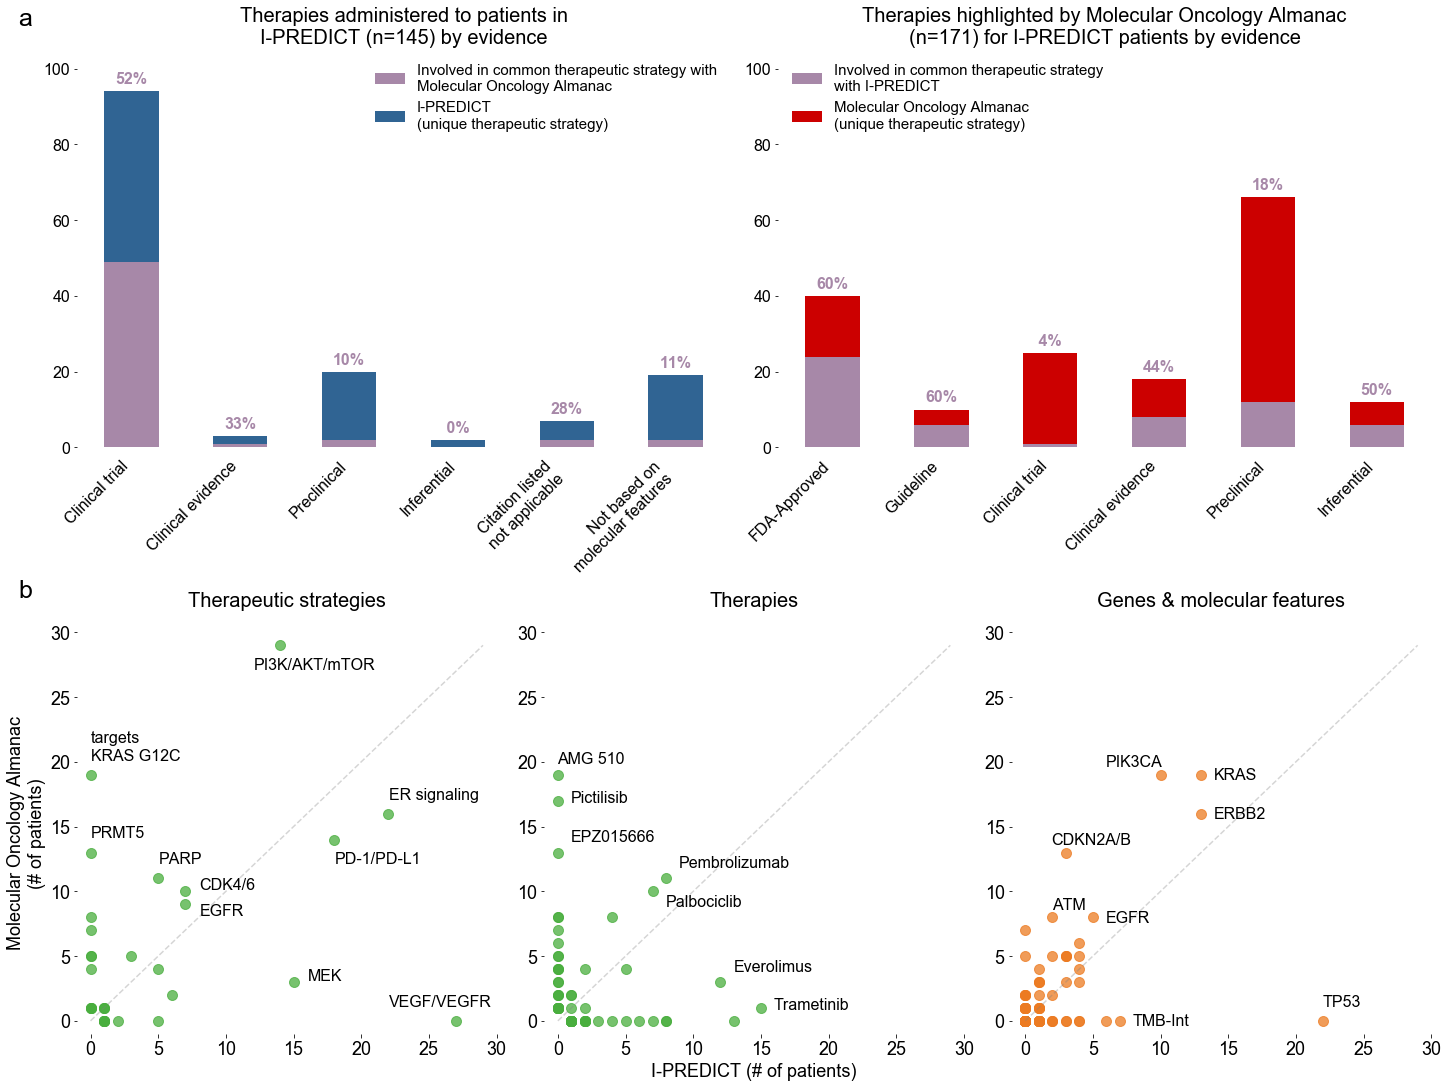

In [18]:
font_size_legend = 15
font_size_data = 16
font_size_axis_label = 18
font_size_tick_params = 18
font_size_title_minor = 20
font_size_title_major = 22

figure = plt.figure(figsize=(20, 15), constrained_layout=True)
gs = figure.add_gridspec(nrows=2, ncols=6)

# ax2: Comparison of therapies (I-PREDICT) with unique and shared strategies per patient by evidence level
ax2 = figure.add_subplot(gs[0, 0:3])
p2 = data_a0.plot(kind='bar', color=[purple, blue], stacked=True, fontsize=font_size_data, rot=45, ax=ax2)
label_by_height(data_a0, ax2)

plt.tick_params(axis="both", which="both", 
                bottom=False, top=False, left=True, right=False,    
                labelbottom=True, labeltop=False, labelleft=True, labelright=False) 
plt.xticks(horizontalalignment='right')
plt.legend(frameon=False, fontsize=font_size_legend, loc=0)

ax2_limit = 105 # roundup(data_a0.iloc[:, :2].sum(axis=1).max(), 5)
ax2.set_ylim([-1, ax2_limit])

value = therapies[therapies['study-evidence-strongest'].notnull()].shape[0]
title = 'Therapies administered to patients in\nI-PREDICT (n={}) by evidence'.format(value)
ax2.set_title(title, fontsize=font_size_title_minor)

# ax3: Comparison of therapies (MOAlmanac) with unique and shared strategies per patient by evidence level
ax3 = figure.add_subplot(gs[0, 3:])
p3 = data_a1.plot(kind='bar', color=[purple, red], stacked=True, fontsize=font_size_data, rot=45, ax=ax3)
label_by_height(data_a1, ax3)

plt.tick_params(axis="both", which="both", 
                bottom=False, top=False, left=True, right=False,    
                labelbottom=True, labeltop=False, labelleft=True, labelright=False) 
plt.xticks(horizontalalignment='right')
plt.legend(frameon=False, fontsize=font_size_legend, loc=2)

ax3_limit = 105 # roundup(data_a1.iloc[:, :2].sum(axis=1).max(), 5)
ax3.set_ylim([-1, ax3_limit])

value = therapies[therapies['almanac-evidence-strongest'].notnull()].shape[0]
title = 'Therapies highlighted by Molecular Oncology Almanac\n(n={}) for I-PREDICT patients by evidence'.format(value)
ax3.set_title(title, fontsize=font_size_title_minor)

# ax4: Scatter of therapeutic strategies
ax4 = figure.add_subplot(gs[1, :2])
p4 = data_b0.plot(kind='scatter', x='study', y='almanac', s=100, alpha=0.75, ax=ax4, color=green)

ax4_limit = 30 # roundup(int(max(data_b0['study'].max(), data_c0['almanac'].max())), 5)
p4_line = plt.plot(range(0, ax4_limit), range(0, ax4_limit), linestyle='--', color='grey', alpha=0.33)

#for idx in data_b0.index:
#    display_label(data_b0, ax4, 9, 9, idx)
    
display_label(data_b0, ax4, 9, 9, 'targets\nKRAS G12C', add_x=0, add_y=1)
display_label(data_b0, ax4, 9, 9, 'PI3K/AKT/mTOR', add_x=-2, add_y=-2)
display_label(data_b0, ax4, 9, 9, 'PRMT5', add_x=0, add_y=1)
display_label(data_b0, ax4, 9, 9, 'CDK4/6', add_x=1, add_y=0)
display_label(data_b0, ax4, 9, 9, 'PARP', add_x=0, add_y=1)
display_label(data_b0, ax4, 9, 9, 'EGFR', add_x=1, add_y=-1)
display_label(data_b0, ax4, 9, 9, 'MEK', add_x=1, add_y=0)
display_label(data_b0, ax4, 9, 9, 'VEGF/VEGFR', add_x=-5, add_y=1)
display_label(data_b0, ax4, 9, 9, 'PD-1/PD-L1', add_x=0, add_y=-2)
display_label(data_b0, ax4, 9, 9, 'ER signaling', add_x=0, add_y=1)

ax4.set_ylabel('Molecular Oncology Almanac\n(# of patients)', fontsize = font_size_axis_label)
ax4.set_xlabel('', fontsize = font_size_axis_label)
ax4.set_ylim([-1, ax4_limit])
ax4.set_xlim([-1, ax4_limit])
ax4.tick_params(axis='both', which='major', labelsize = font_size_tick_params)

title = 'Therapeutic strategies'
ax4.set_title(title, fontsize = font_size_title_minor, y = 1.05)

# ax5: Scatter of therapies
ax5 = figure.add_subplot(gs[1, 2:4])
p5 = data_b1.plot(kind='scatter', x='study', y='almanac', s=100, alpha=0.75, ax=ax5, color=green)

ax5_limit = 30 # roundup(int(max(data_c1['study'].max(), data_c1['almanac'].max())), 5)
p5_line = plt.plot(range(0, ax5_limit), range(0, ax5_limit), linestyle='--', color='grey', alpha=0.33)

#for idx in data_b1.index:
#    display_label(data_b1, ax5, 6, 6, idx)
    
display_label(data_b1, ax5, 6, 6, 'AMG 510', add_x=0, add_y=1)
display_label(data_b1, ax5, 6, 6, 'Pictilisib', add_x=1, add_y=0)
display_label(data_b1, ax5, 6, 6, 'EPZ015666', add_x=1, add_y=1)
display_label(data_b1, ax5, 6, 6, 'Palbociclib', add_x=1, add_y=-1)
display_label(data_b1, ax5, 6, 6, 'Everolimus', add_x=1, add_y=1)
display_label(data_b1, ax5, 6, 6, 'Trametinib', add_x=1, add_y=0)
#display_label(data_b1, ax5, 6, 6, 'Nivolumab', add_x=1, add_y=1)
display_label(data_b1, ax5, 6, 6, 'Pembrolizumab', add_x=1, add_y=1)

ax5.set_ylabel('', fontsize = font_size_axis_label)
ax5.set_xlabel('I-PREDICT (# of patients)', fontsize = font_size_axis_label)
ax5.set_ylim([-1, ax5_limit])
ax5.set_xlim([-1, ax5_limit])
ax5.tick_params(axis='both', which='major', labelsize = font_size_tick_params)

title = 'Therapies'
ax5.set_title(title, fontsize = font_size_title_minor, y = 1.05)

# ax6: Scatter of features
ax6 = figure.add_subplot(gs[1, 4:])
p6 = data_b2.plot(kind='scatter', x='study', y='almanac', s=100, alpha=0.75, ax=ax6, color=orange)

ax6_limit = 30 #roundup(int(max(data_b2['study'].max(), data_b2['almanac'].max())), 5)
p6_line = plt.plot(range(0, ax6_limit), range(0, ax6_limit), linestyle='--', color='grey', alpha=0.33)

display_label(data_b2, ax6, 7.5, 7.5, 'ATM', add_x=0, add_y=1)
display_label(data_b2, ax6, 7.5, 7.5, 'EGFR', add_x=1, add_y=0)
display_label(data_b2, ax6, 7.5, 7.5, 'CDKN2A/B', add_x=-1, add_y=1)
display_label(data_b2, ax6, 7.5, 7.5, 'PIK3CA', add_x=-4, add_y=1)
display_label(data_b2, ax6, 7.5, 7.5, 'KRAS', add_x=1, add_y=0)
display_label(data_b2, ax6, 7.5, 7.5, 'ERBB2', add_x=1, add_y=0)
display_label(data_b2, ax6, 7.5, 7.5, 'TP53', add_x=0, add_y=1.5)
display_label(data_b2, ax6, 0, 0, 'TMB-Int', add_x=1, add_y=0)

ax6.set_ylabel('', fontsize = font_size_axis_label)
ax6.set_xlabel('', fontsize = font_size_axis_label)
ax6.set_ylim([-1, ax6_limit])
ax6.set_xlim([-1, ax6_limit])
ax6.tick_params(axis='both', which='major', labelsize = font_size_tick_params)

title = 'Genes & molecular features'
ax6.set_title(title, fontsize=font_size_title_minor, y = 1.05)

for ax in [ax2, ax3, ax4, ax5, ax6]:
    remove_spines(ax)
    
fig_label_x = 0.01
fig_label_y_a = 0.98
fig_label_y_b = 0.45
font_size_lg = 25

plt.figtext(fig_label_x, fig_label_y_a, 'a', fontsize=font_size_lg)
plt.figtext(fig_label_x, fig_label_y_b, 'b', fontsize=font_size_lg)

folder_name = '../../figures/figure-04'
file_name = 'figure-4'
!mkdir -p $folder_name
for suffix in ['svg', 'png', 'pdf']:
    outname = f'{folder_name}/{file_name}.{suffix}'
    plt.savefig(outname, format=suffix)

plt.show()

In [19]:
import pandas as pd
import openpyxl
with pd.ExcelWriter(f'{folder_name}/{file_name}.xlsx') as writer:  
    data_a0.to_excel(writer, sheet_name='figure 4a - ipredict', index_label='Evidence')
    data_a1.to_excel(writer, sheet_name='figure 4a - moalmanac', index_label='Evidence')
    data_b0.to_excel(writer, sheet_name='figure 4b - strategies', index_label='Strategy')
    data_b1.to_excel(writer, sheet_name='figure 4b - therapies', index_label='Therapy')
    data_b2.to_excel(writer, sheet_name='figure 4b - genes and features', index_label='Gene or molecular feature')

## Summary
1. What strategies are shared and not shared?
2. How many patients do we observe a shared therapeutic strategy?

### What items are shared or not shared?
1. The most common shared strategies are PI3K/AKT/mTOR inhibition and HER2 inhibition, followed by immunotherapy. 
2. I-PREDICT favors VEGF/VEGFR inhibition by targeting TP53 variants
3. Molecular Oncology Almanac commonly recommends PRMT5 based on CDKN2A/B loss

There is likely opportunity to note, perhaps in the discussion, that there is variability as to how the two approaches arrive at the same therapeutic strategy. For example, PI3K/AKT/mTOR us recommended more recent HER2 inhibitors.

In [20]:
idx_shared = therapies['included-in-overlapping-strategy'].eq(1)
idx_almanac = therapies['almanac-evidence-strongest'].notnull()
idx_study = therapies['study-evidence-strongest'].notnull()

therapies[idx_shared].loc[:, ['patient_id', 'strategy']].drop_duplicates()['strategy'].value_counts()

PI3K/AKT/mTOR    9
ER signaling     9
PD-1/PD-L1       8
EGFR             5
CDK4/6           4
MET              4
BRAF             3
MEK              3
PARP             2
RET              1
Chemotherapy     1
Name: strategy, dtype: int64

In [21]:
therapies[~idx_shared & idx_study].loc[:, ['patient_id', 'strategy']].drop_duplicates()['strategy'].value_counts()

VEGF/VEGFR         25
MEK                13
PD-1/PD-L1         10
NSAID               5
ER signaling        5
PI3K/AKT/mTOR       5
PARP                3
CDK4/6              3
Antineoplastic      2
Chemotherapy        2
EGFR                2
MET                 1
RANKL               1
IGF                 1
Wee-1               1
Hedgehog            1
OX40 antagonist     1
ALK                 1
targets BCR-ABL     1
BET                 1
Name: strategy, dtype: int64

In [23]:
therapies[~idx_shared & idx_almanac].loc[:, ['patient_id', 'strategy']].drop_duplicates()['strategy'].value_counts()

targets KRAS G12C                     19
PI3K/AKT/mTOR                         14
PRMT5                                 13
PARP                                   8
FGFR                                   8
MDM2-p53                               7
CDK4/6                                 6
PD-1/PD-L1                             5
Proteasome                             5
ATR                                    5
Aurora kinase                          4
BRAF                                   2
ER signaling                           2
Chemotherapy                           2
EGFR                                   2
IDH1                                   1
Hypomethylating agent chemotherapy     1
ALK                                    1
targets BCR-ABL                        1
IDH2                                   1
MEK                                    1
JAK                                    1
Name: strategy, dtype: int64

In [24]:
therapies[idx_almanac & therapies['strategy'].eq('PI3K/AKT/mTOR')]['therapy'].value_counts()

pictilisib    17
azd8186        4
mk-2206        3
everolimus     3
alpelisib      1
sirolimus      1
Name: therapy, dtype: int64

In [25]:
therapies[therapies['strategy'].eq('PRMT5')].head()

,patient_id,therapy,study-evidence-strongest,almanac-evidence-strongest,included-in-overlapping-strategy,strategy,study-gave-as-matched-therapy,study-citations-used-for-patient,comment-on-study-citation,substrategy,almanac_top_recommendation_group
40,34,epz015666,NaN,Preclinical,0,PRMT5,NaN,NaN,NaN,NaN,0.0
83,73,epz015666,NaN,Preclinical,0,PRMT5,NaN,NaN,NaN,NaN,0.0
116,101,epz015666,NaN,Preclinical,0,PRMT5,NaN,NaN,NaN,NaN,1.0
119,102,epz015666,NaN,Preclinical,0,PRMT5,NaN,NaN,NaN,NaN,1.0
138,119,epz015666,NaN,Preclinical,0,PRMT5,NaN,NaN,NaN,NaN,1.0


In [26]:
features[features['sensitive_therapy_name'].eq('EPZ015666')]['feature'].head()

53     CDKN2A
149    CDKN2A
190    CDKN2A
195    CDKN2A
228    CDKN2A
Name: feature, dtype: object

In [97]:
vegf_patients = therapies[therapies['strategy'].eq('VEGF/VEGFR')]['patient_id'].astype(str).tolist()
tp53_vegf = features[features['feature'].eq('TP53') & features['ipredict_targeted'].eq(1) & features['patient_id'].astype(str).isin(vegf_patients)]
print(tp53_vegf['patient_id'].drop_duplicates().shape)
print('')
tp53_vegf.head()

(18,)



,feature,feature_type,alteration_type,alteration,patient_id,ipredict_targeted,score_bin,sensitive_predictive_implication,resistance_predictive_implication,prognostic_predictive_implication,...,resistance_therapy_strategy,resistance_therapy_type,resistance_description,resistance_citation,resistance_url,prognostic_score_bin,favorable_prognosis,prognostic_description,prognostic_citation,prognostic_url
9,TP53,Somatic Variant,Missense,p.R248Q,9,1,Investigate Actionability,NaN,Guideline,Guideline,...,Immunomodulation,Targeted therapy,More frequent with complex karyotypes and del(...,National Comprehensive Cancer Network. Myelody...,https://www.nccn.org/professionals/physician_g...,Investigate Actionability,0.0,Missense mutation in any codon except P47S or ...,National Comprehensive Cancer Network. Myelody...,https://www.nccn.org/professionals/physician_g...
20,TP53,Somatic Variant,Nonsense,p.R306*,20,1,Investigate Actionability,NaN,Guideline,Guideline,...,Immunomodulation,Targeted therapy,More frequent with complex karyotypes and del(...,National Comprehensive Cancer Network. Myelody...,https://www.nccn.org/professionals/physician_g...,Investigate Actionability,0.0,Mutations in TP53 correlated with shorter over...,National Comprehensive Cancer Network. Myelody...,https://www.nccn.org/professionals/physician_g...
59,TP53,Somatic Variant,Missense,p.R175H,34,1,Investigate Actionability,NaN,Guideline,Guideline,...,Immunomodulation,Targeted therapy,More frequent with complex karyotypes and del(...,National Comprehensive Cancer Network. Myelody...,https://www.nccn.org/professionals/physician_g...,Investigate Actionability,0.0,Missense mutation in any codon except P47S or ...,National Comprehensive Cancer Network. Myelody...,https://www.nccn.org/professionals/physician_g...
67,TP53,Somatic Variant,Missense,p.R282W,39,1,Investigate Actionability,NaN,Guideline,Guideline,...,Immunomodulation,Targeted therapy,More frequent with complex karyotypes and del(...,National Comprehensive Cancer Network. Myelody...,https://www.nccn.org/professionals/physician_g...,Investigate Actionability,0.0,Missense mutation in any codon except P47S or ...,National Comprehensive Cancer Network. Myelody...,https://www.nccn.org/professionals/physician_g...
106,TP53,Somatic Variant,Missense,p.V157F,48,1,Investigate Actionability,NaN,Guideline,Guideline,...,Immunomodulation,Targeted therapy,More frequent with complex karyotypes and del(...,National Comprehensive Cancer Network. Myelody...,https://www.nccn.org/professionals/physician_g...,Investigate Actionability,0.0,Missense mutation in any codon except P47S or ...,National Comprehensive Cancer Network. Myelody...,https://www.nccn.org/professionals/physician_g...


### How many patients observe a shared therapeutic strategy?

In [27]:
# Number of patients with overlapping strategies
therapies[idx_shared]['patient_id'].drop_duplicates().shape

(39,)

In [28]:
# Total N patients
therapies['patient_id'].drop_duplicates().shape

(83,)

In [29]:
# % of patients with overlapping strategies
therapies[idx_shared]['patient_id'].drop_duplicates().shape[0] / therapies['patient_id'].drop_duplicates().shape[0]

0.46987951807228917

In [32]:
# Number of drugs in I-PREDICT
therapies.loc[therapies['study-evidence-strongest'].dropna().index, 'therapy'].drop_duplicates().shape

(45,)

In [33]:
# Number of drugs MOAlmanac
therapies.loc[therapies['almanac-evidence-strongest'].dropna().index, 'therapy'].drop_duplicates().shape

(40,)

In [34]:
# Number of strategies
therapies['strategy'].dropna().drop_duplicates().shape

(33,)

In [49]:
# Number of patients with a MOAlmanac therapy involved in overlapping strategy
# being in the highest prioritized group highlighted 
therapies.loc[therapies['included-in-overlapping-strategy'].eq(1) & therapies['almanac_top_recommendation_group'], 'patient_id'].drop_duplicates().shape

(31,)

In [63]:
## Patients with FDA or guideline association by MOAlmanac that were not involved in an overlapping strategy
idx_standard = therapies['almanac-evidence-strongest'].fillna('').isin(['FDA-Approved', 'Guideline'])
idx_overlap = therapies['included-in-overlapping-strategy'].fillna(-1).eq(1)
therapies.loc[idx_standard, 'patient_id'].drop_duplicates().shape

(35,)

In [77]:
patients_std = therapies.loc[idx_standard, 'patient_id'].drop_duplicates()
patients_std_overlap = therapies.loc[idx_standard & idx_overlap, 'patient_id'].drop_duplicates()
patients_std_not_overlap = pd.Index(patients_std).difference(pd.Index(patients_std_overlap))
print(patients_std_not_overlap.shape)
patients_std_not_overlap

(10,)


Index(['112', '34', '51', '53', '66', '89', '97', 'A037', 'A040', 'A042'], dtype='object', name='patient_id')

In [99]:
therapies[therapies['patient_id'].isin(patients_std_not_overlap)]

,patient_id,therapy,study-evidence-strongest,almanac-evidence-strongest,included-in-overlapping-strategy,strategy,study-gave-as-matched-therapy,study-citations-used-for-patient,comment-on-study-citation,substrategy,almanac_top_recommendation_group
37,34,lenvatinib,Preclinical,NaN,0,VEGF/VEGFR,1.0,"2,5,6,16,17",VEGF/VEGFR,NaN,NaN
38,34,nivolumab,NaN,Clinical evidence,0,PD-1/PD-L1,NaN,NaN,NaN,NaN,0.0
39,34,pembrolizumab,NaN,Clinical evidence,0,PD-1/PD-L1,NaN,NaN,NaN,NaN,0.0
40,34,epz015666,NaN,Preclinical,0,PRMT5,NaN,NaN,NaN,NaN,0.0
41,34,erdafitinib,NaN,FDA-Approved,0,FGFR,NaN,NaN,NaN,NaN,1.0
42,34,niraparib,NaN,FDA-Approved,0,PARP,NaN,NaN,NaN,NaN,0.0
43,34,neratinib,NaN,Clinical evidence,0,ER signaling,NaN,NaN,NaN,NaN,0.0
58,51,lenvatinib,Preclinical,NaN,0,VEGF/VEGFR,1.0,"16,17,19","Citations 16, 17 look at lenvatinib in particu...",NaN,NaN
59,51,olaparib,Clinical trial,FDA-Approved,0,PARP,1.0,"16,17,19",Citation 19 is a review focused on olaparib fo...,NaN,1.0
60,51,pembrolizumab,NaN,FDA-Approved,0,PD-1/PD-L1,NaN,NaN,NaN,NaN,1.0


In [50]:
non_standard = therapies[~(therapies['almanac-evidence-strongest'].fillna('').isin(['FDA-Approved', 'Guideline', '']))]

In [51]:
non_standard_counts = non_standard['included-in-overlapping-strategy'].value_counts()
non_standard_counts

0    94
1    27
Name: included-in-overlapping-strategy, dtype: int64

In [52]:
non_standard_counts.divide(non_standard_counts.sum())

0    0.77686
1    0.22314
Name: included-in-overlapping-strategy, dtype: float64

In [38]:
non_standard_counts.sum()

121

In [39]:
non_standard

,patient_id,therapy,study-evidence-strongest,almanac-evidence-strongest,included-in-overlapping-strategy,strategy,study-gave-as-matched-therapy,study-citations-used-for-patient,comment-on-study-citation,substrategy,almanac_top_recommendation_group
2,5,nutlin-3,NaN,Preclinical,0,MDM2-p53,NaN,NaN,NaN,NaN,0.0
5,7,amg 510,NaN,Clinical trial,0,targets KRAS G12C,NaN,NaN,NaN,NaN,1.0
7,9,amg 510,NaN,Clinical trial,0,targets KRAS G12C,NaN,NaN,NaN,NaN,1.0
9,15,nutlin-3,NaN,Preclinical,0,MDM2-p53,NaN,NaN,NaN,NaN,0.0
11,19,pictilisib,NaN,Preclinical,0,PI3K/AKT/mTOR,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...
290,A043,neratinib,NaN,Clinical evidence,1,ER signaling,NaN,NaN,NaN,TKI,0.0
291,A043,amg 510,NaN,Clinical trial,0,targets KRAS G12C,NaN,NaN,NaN,NaN,1.0
295,A044,everolimus,NaN,Clinical evidence,0,PI3K/AKT/mTOR,NaN,NaN,NaN,NaN,1.0
298,A045,amg 510,NaN,Clinical trial,0,targets KRAS G12C,NaN,NaN,NaN,NaN,1.0


In [40]:
standard = therapies[(therapies['almanac-evidence-strongest'].fillna('').isin(['FDA-Approved', 'Guideline']) | therapies['almanac-evidence-strongest'].isnull())]
standard['included-in-overlapping-strategy'].value_counts()

0    107
1     72
Name: included-in-overlapping-strategy, dtype: int64

In [41]:
standard.drop_duplicates(['therapy', 'almanac-evidence-strongest'])

,patient_id,therapy,study-evidence-strongest,almanac-evidence-strongest,included-in-overlapping-strategy,strategy,study-gave-as-matched-therapy,study-citations-used-for-patient,comment-on-study-citation,substrategy,almanac_top_recommendation_group
0,2,crizotinib,Clinical trial,Guideline,1,MET,1.0,1,I could not get access to this article; howeve...,NaN,1.0
1,5,palbociclib,Clinical trial,Guideline,1,CDK4/6,1.0,2,Citation 2 describes clinical trials of CDK4 i...,NaN,1.0
3,7,gemcitabine,Not based on molecular features,NaN,0,Chemotherapy,0.0,Not applicable,NaN,NaN,NaN
4,7,nab-paclitaxel,Not based on molecular features,NaN,0,Chemotherapy,0.0,Not applicable,NaN,NaN,NaN
6,9,bevacizumab,Inferential,NaN,0,VEGF/VEGFR,1.0,3,Citation 3 describes VEGF inhibition showing e...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
281,A042,irinotecan,Not based on molecular features,NaN,0,Antineoplastic,0.0,Not applicable,NaN,NaN,NaN
283,A042,denosumab,Not based on molecular features,NaN,0,RANKL,0.0,Not applicable,NaN,NaN,NaN
292,A044,cyclophosphamide,Not based on molecular features,NaN,0,Chemotherapy,0.0,Not applicable,NaN,NaN,NaN
293,A044,dacarbazine,Not based on molecular features,NaN,0,Chemotherapy,0.0,Not applicable,NaN,NaN,NaN


In [42]:
standard = therapies[therapies['almanac-evidence-strongest'].fillna('').isin(['FDA-Approved', 'Guideline'])]
standard.head()

,patient_id,therapy,study-evidence-strongest,almanac-evidence-strongest,included-in-overlapping-strategy,strategy,study-gave-as-matched-therapy,study-citations-used-for-patient,comment-on-study-citation,substrategy,almanac_top_recommendation_group
0,2,crizotinib,Clinical trial,Guideline,1,MET,1.0,1,I could not get access to this article; howeve...,NaN,1.0
1,5,palbociclib,Clinical trial,Guideline,1,CDK4/6,1.0,2,Citation 2 describes clinical trials of CDK4 i...,NaN,1.0
8,15,palbociclib,Clinical trial,Guideline,1,CDK4/6,1.0,2,Citation 2 describes clinical trials of CDK4 i...,NaN,1.0
18,22,ado-trastuzumab emtansine,NaN,FDA-Approved,1,ER signaling,NaN,NaN,NaN,NaN,1.0
20,23,cetuximab,Clinical trial,FDA-Approved,1,EGFR,1.0,"11,12,13,14,15",Citations looked at V600 mutants in different ...,NaN,1.0


How many therapies does moalmanac highlight on average, that were not administered?

In [43]:
therapies[~therapies['almanac-evidence-strongest'].isnull() & therapies['study-evidence-strongest'].isnull()]['patient_id'].value_counts().describe()

count    75.000000
mean      2.066667
std       1.338952
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       6.000000
Name: patient_id, dtype: float64